<a href="https://colab.research.google.com/github/andreanatile/Fondamentals-of-ML-code/blob/main/CornDesease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load data
In  google colab "secrests" i have uploaded my kaggle credential, so every time i run this code it will get the credential from the user data in order to access the Kaggle API.

In [1]:
from google.colab import userdata
import os

# I've insert in google colab secret my username and key of kaggle
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

Using the kaggle API i can download in google colab's machine the Corn leaf dataset, so it is not stored in the local mememory but on the google colab server. After the download we unzip it.

In [ ]:
!kaggle datasets download -d qramkrishna/corn-leaf-infection-dataset

! unzip "corn-leaf-infection-dataset.zip"

In [1]:
import tensorflow as tf
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#2. Remove dodgy image
We check the dataset in order to remove all the file that are not images. In order to do that we compare the extention of the file with the list image_exts that contain all possible extenction for an image.

In [2]:
import cv2
import imghdr

In [3]:
data_dir = '/content/Corn Disease detection'

In [4]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

The process of checking every image extention for a dataset of 13GB take circa 4 minutes. Since we found only one file that is not an image we directly eliminate it instead of doing all the process for every run.

In [8]:
#os.remove('/content/Corn Disease detection/Infected/Annotation-export.csv')
"""
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Not an image {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
"""

"\nfor image_class in os.listdir(data_dir):\n    for image in os.listdir(os.path.join(data_dir, image_class)):\n        image_path = os.path.join(data_dir, image_class, image)\n        try:\n            img = cv2.imread(image_path)\n            tip = imghdr.what(image_path)\n            if tip not in image_exts:\n                print('Not an image {}'.format(image_path))\n                os.remove(image_path)\n        except Exception as e:\n            print('Issue with image {}'.format(image_path))\n            # os.remove(image_path)\n"

# 3. Load data
Instead of loading and preprocessing the data with standard pandas and numpy i have decided to utilize **tf.keras.utils.image_dataset_from_directory**.

Using such large datasets with pandas and numpy methods would mean loading the entire dataset into memory, and since the google colab ram available is 12GB it would be impratical and slow down the processing.

Instead, leveraging **tf.keras.utils.image_dataset_from_directory** allowed to create a pipeline for processing images in batches. By doing so, I avoided the need to load the entire dataset into RAM at once,  mitigating memory issues. This batching process enabled me to work with manageable chunks of data at a time, optimizing memory usage and enhancing computational efficiency.

For a better undertanding of this method:
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [5]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

**tf.keras.utils.image_dataset_from_directory** reads images directly from the directory, organizing them into a dataset.

we can decide the size of the images.

It organizes the images into batches, allowing to process multiple images simultaneously. In this case i have adopted for batch fo 32 images.

 it shuffles the dataset to ensure randomness in each batch, which helps prevent biases during training. we can specify the seed so we can make replicable this shuffles

it splits the dataset into training and validation sets based on the percentage you specify. This is useful fbecause we can automatically create training and test set directly from keras.

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   batch_size=32,
                                                   image_size=(128,128),
                                                   shuffle=True,
                                                   seed=42)

Found 4225 files belonging to 2 classes.


**data.as_numpy_iterator()**  This iterator allows to iterate over the dataset and retrieve batches of data in the form of NumPy arrays.

In [13]:
data_iterator = data.as_numpy_iterator()

This line retrieves the next batch of data from the iterator data_iterator and assigns it to the variable batch.

In [14]:
batch = data_iterator.next()


The batch consists of a tuple comprising two elements: a NumPy array containing a batch of images and their corresponding labels. The first element of the tuple is a NumPy array containing 32 RGB images, each with dimensions of 256x256 pixels. The second element of the tuple is another NumPy array that stores the class of each image, indicating whether it is infected (1) or healthy (0).

In [15]:
print(f'data type of variable batch: {type(batch)}')
print(f'The lenght of the batch is: {len(batch)}')
print(f'The first element of batch is {type(batch[0])}')
print(f'Shape of the first element of the batch {batch[0].shape}')
print(f'The secodn element of the batch if {type(batch[1])}')
print(f'Shape of the second element of the batch {batch[1].shape}')


data type of variable batch: <class 'tuple'>
The lenght of the batch is: 2
The first element of batch is <class 'numpy.ndarray'>
Shape of the first element of the batch (32, 128, 128, 3)
The secodn element of the batch if <class 'numpy.ndarray'>
Shape of the second element of the batch (32,)


For understanding we plot the images inside the batch

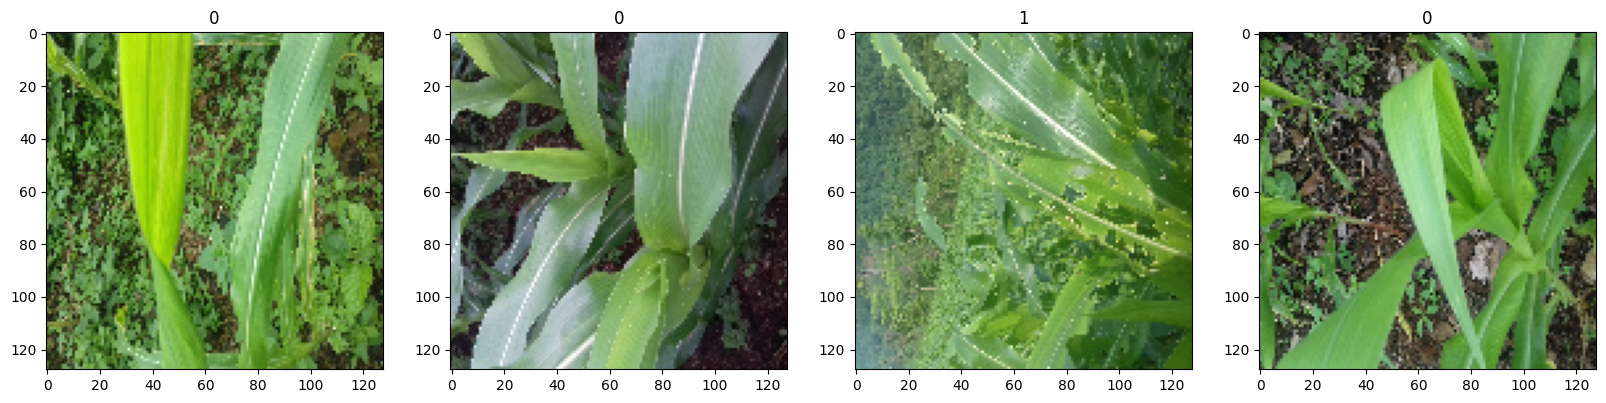

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Preprocessing the data
Before proceeding with further analysis or modeling, it's crucial to preprocess the image data. This involves transforming the images into black and white and normalizing them.

##Convert to Grayscale:
RGB images are converted to grayscale, reducing each pixel's color information to a single intensity value. This reduce the the dimension of the dataset

## Normalization
Pixel values in the grayscale images are normalized to a range between 0 and 1.

## Flatten image
The 2D image matrices are flattened into 1D vectors in order to store in a dataset and apply PCA.

In [6]:
# Function to normalize data
def normalize(image, label):
    img = tf.cast(image, tf.float32)
    # Normalize pixel
    img /= 255.0

    return img, label
# Function for trasforming RGB images in black and white
def grayscale(img, y):
    gray_image = tf.image.rgb_to_grayscale(img)
    return gray_image, y

# Function for trasforming the image(matrix) in a vector
# it will be useful for pca
def flatten_images(image_batch, label_batch):
    return tf.reshape(image_batch, (tf.shape(image_batch)[0], -1)), label_batch



Considering that the predominant color in the images is green, a way to reduce the weight of the dataset to convert them into binary color, specifically black and white. In this scheme, pixels representing green areas would be assigned a value of 1, while darker regions ( holes or infections), would be assigned a value of 0.
This approach create visual contrast that facilitates subsequent analysis and anomaly detection.






In [7]:
def threshold(img, y):
    thresholded_image = tf.where(img > 0.5, tf.ones_like(img), tf.zeros_like(img))
    return thresholded_image, y

**tf.keras.utils.image_dataset_from_directory** has the possibility to divide the data in training and validation and we can specify even the validation_split percentage. In this case we have fixed it at 20%.

 Each map call appends the corresponding function to the preprocessing pipeline of training and test, ensuring that each image in the dataset undergoes these preprocessing steps sequentially.

 This approach store in RAM only the preprocessed data batch, and not the entire original data. It helps having a more clear and clean preprocessing step.

Found 4225 files belonging to 2 classes.
Using 3380 files for training.
Found 4225 files belonging to 2 classes.
Using 845 files for validation.
(32, 320, 320, 1)


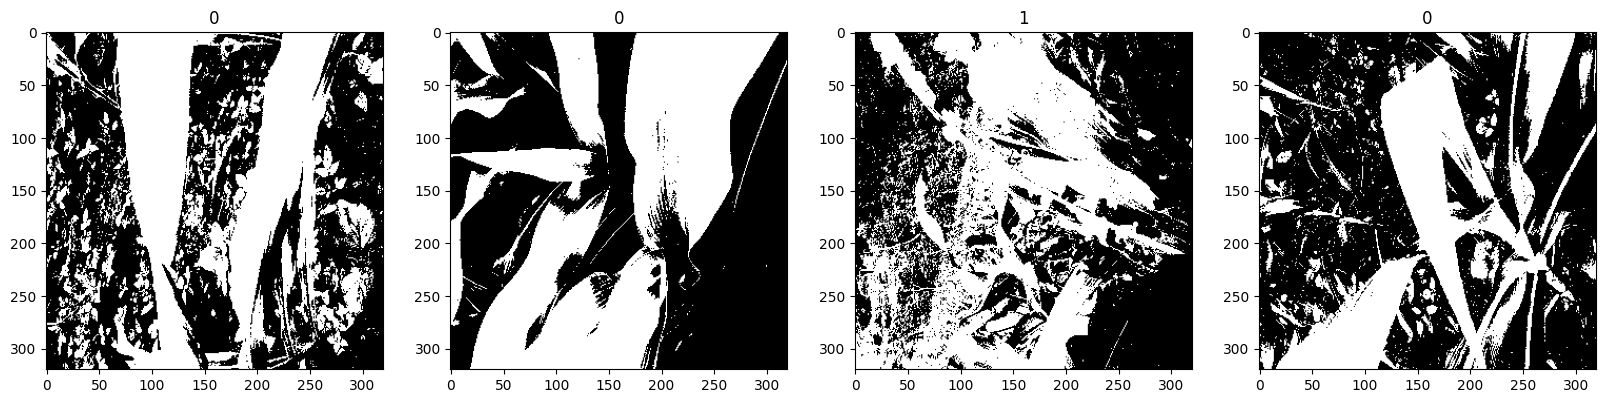

In [8]:
# Load the dataset
training_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=32,
    image_size=(320, 320),
    validation_split=0.2,
    subset='training',
    seed=42
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=32,
    image_size=(320,320),
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Apply preprocessing to the datasets
training_data = training_data.map(grayscale)
training_data = training_data.map(normalize)
training_data = training_data.map(threshold)

validation_data = validation_data.map(grayscale)
validation_data = validation_data.map(normalize)
validation_data = validation_data.map(threshold)

# Show the result of preprocessing
training_iterator = training_data.as_numpy_iterator()
batch = training_iterator.next()
print(batch[0].shape)
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(batch[1][idx])
plt.show()


In order to apply the PCA and the Neural network we trasform the batches in numpy array.

In [9]:
# Convert datasets to numpy arrays
X_train = []
y_train = []
for image_batch, label_batch in training_data:
    flattened_images, labels = flatten_images(image_batch, label_batch)
    X_train.append(flattened_images.numpy())
    y_train.append(labels.numpy())

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

X_test=[]
y_test=[]
for image_batch, label_batch in validation_data:
    flattened_images, labels = flatten_images(image_batch, label_batch)
    X_test.append(flattened_images.numpy())
    y_test.append(labels.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)


[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


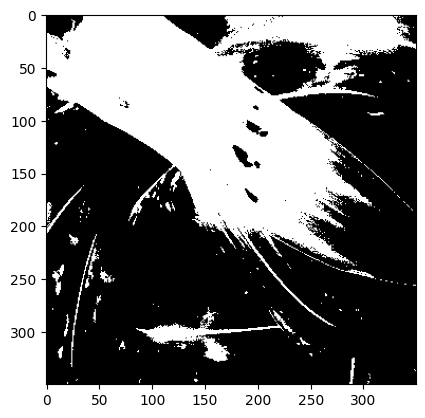

In [ ]:
print(X_train[:5,:5])
v=X_train[150]
img=np.reshape(v,(350,350))
plt.imshow(img,cmap='gray')

In [10]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# 5. Reduce the dimension of the dataset with PCA

Thanks to PCA we can reduce the dimension of our dataset keeping the more variance as possible. In this case we have found that the best predicting performance are when we retain 99% of our variance.

In [22]:
import numpy as np
class PCA:
  def __init__(self, n_components=None, variance_retained=None):
    self.n_components = n_components
    self.variance_retained = variance_retained
    self.U_reduced = None

  def fit(self, X):
    X = X - np.mean(X, axis=0)
    cov = np.dot(X.T, X)
    U, S, Vt = np.linalg.svd(cov)

    if self.variance_retained is not None:
      total_variance = np.sum(S)
      cumulative_variance_ratio = np.cumsum(S) / total_variance
      self.n_components = np.argmax(cumulative_variance_ratio >= self.variance_retained) + 1

      self.U_reduced = U[:, :self.n_components]

  def transform(self, X):
    X_centered = X - np.mean(X, axis=0)
    X_reduced = np.dot(X_centered, self.U_reduced)
    return X_reduced

  def fit_transform(self, X):
    self.fit(X)
    X_reduced = self.transform(X)
    return X_reduced


In [ ]:
import numpy as np
np.random.seed(42)
pca= PCA(variance_retained=0.99)
x_train_pca=pca.fit_transform(X_train)
x_test_pca=pca.transform(X_test)

print(f'With a tollerance of 0.99 we reduce the dimension of the dataset \n'
        f'from {X_train.shape[1]} to {x_train_pca.shape[1]} ')

In [11]:
np.random.seed(42)
from sklearn.decomposition import PCA
pca= PCA(0.99)
x_train_pca=pca.fit_transform(X_train)
x_test_pca=pca.transform(X_test)

print(f'With a tollerance of 0.95 we reduce the dimension of the dataset \n'
        f'from {X_train.shape[1]} to {x_train_pca.shape[1]} ')

With a tollerance of 0.95 we reduce the dimension of the dataset 
from 102400 to 3124 


To better show the result on reducing the dimension and the size of our images, this code below show that only the preprocessing step bring the size of the dataset from 13GB to 1.1GB.

with PCA we further reduce the dimension bringing it to 8MB.

In [12]:
import sys
dataset_preprocessed_size=(sys.getsizeof(X_train)+sys.getsizeof(X_test)+
                           sys.getsizeof(y_test)+sys.getsizeof(y_train))/1e9
dataset_pca_size=(sys.getsizeof(x_train_pca)+sys.getsizeof(x_test_pca)+
                           sys.getsizeof(y_test)+sys.getsizeof(y_train))/1e6
print(f'Size of the dataset after preprocessing: {dataset_preprocessed_size}GB')
print(f'Size of the dataset after PCA: {dataset_pca_size}MB')

Size of the dataset after preprocessing: 1.73057738GB
Size of the dataset after PCA: 10.5765MB


# 6. Create the neural network

We implement a Neural network for classification utilizing torch. utilizng torch, thanks to the library 'cuda' developed by NVidia we are able to use GPU for the training of the NN. Greatly improving the speed of this process.

In [13]:
import torch
from torch import nn,optim

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

We build from scratch the NN using torch.

This NN will have 3 hidden layer and the activation function for the non linear layers is the ReLU. In the last layer for the purpose of classification we use the Sigmoid function.

In [14]:
torch.manual_seed(42)
class NN(nn.Module):
  def __init__(self,input_size,hidden_size1,hidden_size2,hidden_size3,output_size):
    super(NN,self).__init__()
    self.fc1=nn.Linear(input_size,hidden_size1)
    self.fc2=nn.Linear(hidden_size1,hidden_size2)
    self.fc3=nn.Linear(hidden_size2,hidden_size3)
    self.fc4=nn.Linear(hidden_size3,output_size)

    self.activation=nn.ReLU() # For the hidden layers
    self.sigmoid=nn.Sigmoid() # For the last layer
    self.h1=hidden_size1
    self.h2=hidden_size2
    self.h3=hidden_size3

  def forward(self,X):
    X=self.fc1(X)
    X=self.activation(X)

    X=self.fc2(X)
    X=self.activation(X)

    X=self.fc3(X)
    X=self.activation(X)

    X=self.fc4(X)
    X=self.sigmoid(X)
    return X

  def fit(self, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, criterion,optimizer,stop_condition=15,epochs=100):
    best_acc = 0
    # Keep track of the histories of test and train accuracy
    # in order to diagnose the NN
    history_test=[]
    history_train=[]

    for epoch in range(epochs):
      self.train()
      outputs = self(x_train_tensor)
      outputs = outputs.squeeze()
      loss = criterion(outputs, y_train_tensor)
      outputs = torch.round(outputs).float()
      acc_train = accuracy_score(y_train_tensor, outputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      self.eval()

      with torch.no_grad():
        outputs_test = self(x_test_tensor)
        outputs_test = outputs_test.squeeze()
        loss_test = criterion(outputs_test, y_test_tensor)
        outputs_test = torch.round(outputs_test).float()
        acc_test = accuracy_score(y_test_tensor, outputs_test)

        # Append the accuracy
        history_test.append(acc_test)
        history_train.append(acc_train)
       # Introduce early stopping in order to prevent overfitting

        if acc_test > best_acc:
          best_acc = acc_test
          best_epoch = epoch
          no_improvement_count = 0
        else:
          # If the accuracy test is not growing we increase the no_improvement count
          no_improvement_count += 1

            # we give the model a margin of epochs to grow, after that we stop
            # the training and we return the best accuracy test and its epoch
        if no_improvement_count >= stop_condition:
          print(f'Early stopping at epoch {epoch}, best validation accuracy: {best_acc}')
          break
    return best_acc,best_epoch,history_train,history_test


  def predict(self,x_test):
    outputs_test=self(x_test)
    outputs_test = outputs_test.squeeze()
    outputs_test=torch.round(outputs_test).float()
    return outputs_test





def accuracy_score(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  return correct/len(y_true)*100

In [ ]:

import torch

def compute_confusion_matrix(y_true,y_pred):
  # since y_pred is a PyTorch stored in GPU
  outputs_test_cpu = outputs_test.cpu().numpy()
  conf_matrix = confusion_matrix(y_test, outputs_test_cpu)
  return conf_matrix



We implement a grid search to find the best hyperparameters, including the number of hidden layers for the NN.

In [ ]:
x_train_tensor=torch.from_numpy(x_train_pca).float().to(device)
y_train_tensor=torch.from_numpy(y_train).float().to(device)
x_test_tensor=torch.from_numpy(x_test_pca).float().to(device)
y_test_tensor=torch.from_numpy(y_test).float().to(device)

torch.manual_seed(42)
from sklearn.model_selection import ParameterGrid

input_size=x_train_pca.shape[1]
output_size=1

param_grid={
    'lr':[1e-2,1e-1],
    'C':[0,10],
    'h1':[400,800,900,1000,1500,2000],
    'h2':[2000,3000,4000,5000],
    'h3':[700,800,1000,1500,2000]
}

# Create all possible combination of hyperparameters
grid=ParameterGrid(param_grid)

total_best_acc=0
total_best_hyperparameter={}
best_history=[]
for param in grid:
  model = NN(input_size, param['h1'], param['h2'], param['h3'], output_size).to(device)
  criterion=nn.BCELoss()
  optimizer=optim.SGD(model.parameters(),lr=param['lr'],weight_decay=param['C'])
  best_acc,best_epoch,history_train,history_test=model.fit(x_train_tensor,
                                                          y_train_tensor,
                                                          x_test_tensor,
                                                          y_test_tensor,
                                                          criterion,optimizer,
                                                           stop_condition=7)
  # Save the best model and its accuracy
  if best_acc>total_best_acc:
    total_best_acc=best_acc
    best_hyperparameter=param
    best_history_train=history_train
    best_history_test=history_test
    best_model=model

print(total_best_acc)
print(best_hyperparameter)
print(best_epoch)


Early stopping at epoch 29, best validation accuracy: 65.56213017751479
Early stopping at epoch 33, best validation accuracy: 69.11242603550296
Early stopping at epoch 25, best validation accuracy: 63.66863905325444
Early stopping at epoch 42, best validation accuracy: 68.04733727810651
Early stopping at epoch 61, best validation accuracy: 69.8224852071006
Early stopping at epoch 30, best validation accuracy: 68.04733727810651
Early stopping at epoch 45, best validation accuracy: 66.74556213017752
Early stopping at epoch 21, best validation accuracy: 67.45562130177515
Early stopping at epoch 35, best validation accuracy: 68.40236686390533
Early stopping at epoch 28, best validation accuracy: 68.63905325443787
Early stopping at epoch 76, best validation accuracy: 68.16568047337277
Early stopping at epoch 7, best validation accuracy: 53.964497041420124
Early stopping at epoch 56, best validation accuracy: 67.10059171597634
Early stopping at epoch 7, best validation accuracy: 55.857988165

In [ ]:
import matplotlib.pyplot as plt

# Plotting train
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_history_train) + 1), best_history_train, marker='o', linestyle='-')
plt.title('Train Accuracy Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

# Plotting test
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_history_test) + 1), best_history_test, marker='o', linestyle='-')
plt.title('Test Accuracy Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()